# Data Wrangling Project - WeRateDogs Twitter Archive

## Introduction
WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively for you to use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017.

![WeRateDogs Twitter](https://video.udacity-data.com/topher/2017/October/59dd378f_dog-rates-social/dog-rates-social.jpg)

### Project Steps Overview
With the main focus of this project being on data wrangling, it will be divided into the following steps:
1. Gathering data
2. Assessing data
3. Cleaning data
4. Storing data
5. Analyzing and visualizing data
6. Reporting
      - My data wrangling efforts
      - My data analyses and visualizations.

### Aim
The goal is to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.

### The Data
In this project, I will work on the following three datasets.

##### Enhanced Twitter Archive
This data was provided by the Udacity team. The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which was used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, they filtered for tweets with ratings only (there are 2356).
![image.png](https://video.udacity-data.com/topher/2017/October/59dd4791_screenshot-2017-10-10-18.19.36/screenshot-2017-10-10-18.19.36.png)

They extracted this data programmatically, but they didn't do a very good job. The ratings probably aren't all correct. Same goes for the dog names and probably dog stages (see below for more information on these) too. I'll need to assess and clean these columns if I want to use them for analysis and visualization.

##### Additional Data via the Twitter API
Back to the basic-ness of Twitter archives: ***retweet count*** and ***favorite count*** are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. Since I have access to Twitter's API and the tweet IDs of the tweets in the Enhanced archive, I can gather the needed data for all 5000+ by querying Twitter's API.

##### Image Predictions File
Every image in the WeRateDogs Twitter archive was run through a neural network that can classify breeds of dogs. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).
![imgpredict](https://video.udacity-data.com/topher/2017/October/59dd4d2c_screenshot-2017-10-10-18.43.41/screenshot-2017-10-10-18.43.41.png)

So for the last row in that table:
* `tweet_id` is the last part of the tweet URL after "status/" → https://twitter.com/dog_rates/status/889531135344209921
* `p1` is the algorithm's #1 prediction for the image in the tweet → **golden retriever**
* `p1_conf` is how confident the algorithm is in its #1 prediction → **95%**
* `p1_dog` is whether or not the #1 prediction is a breed of dog → **TRUE**
* `p2` is the algorithm's second most likely prediction → **Labrador retriever**
* `p2_conf` is how confident the algorithm is in its #2 prediction → **1%**
* `p2_dog` is whether or not the #2 prediction is a breed of dog → **TRUE**
* etc.

## Gathering Data

In [2]:
#%pip install tweepy

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import os
from bs4 import BeautifulSoup

### Data downloaded manually
The WeRateDogs Twitter archive was given to us by hand, so let's read it into a pandas dataframe.

In [2]:
twitter_enhanced_df = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
twitter_enhanced_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Data from Web
Downloading the **tweet image predictions** programmatically using the `requests` library.

In [5]:
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

In [15]:
with open("image_predictions.tsv",mode='wb') as file:
      file.write(response.content)

In [16]:
os.listdir()

['image_predictions.tsv',
 'twitter-archive-enhanced.csv',
 'WeRateDogs Twitter_Data Wrangling Project.ipynb']

In [8]:
img_predictions_df = pd.read_csv('image_predictions.tsv', sep='\t')

In [19]:
img_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Data from API
Use Tweepy to query Twitter's API for the retweet count and favorite count for each tweet.

- Create API object
- Create empty list for containing dictionary with keys 'tweet_id' and 'json_string' or 'tweet_data'
- Create an empty list for storing errors
- Iterate through the tweet_id in the twitter_enhanced_df
- Use the try-except statement to catch errors
- Monitor each iterations time.
- Get status of tweet
- Convert json status to string so that it can be stored.
- Store the tweet_id and json_string in a dictionary
- Store dictionary in empty list
- Store errors in list.
- Work on the errors
- Store each json_string in a new line in `tweet_json.txt` file

In [71]:
import tweepy
import timeit

My API keys, secrets and tokens won't be included this report. You can get yours by signing up for the [Twitter Developer Account](https://developer.twitter.com)

In [27]:
api_key = "your api key"
api_key_secret = "your api key secret"
access_token = "your access token"
access_token_secret = "your access token secret"

Creating the API object that I'll use to gather Twitter data.

In [36]:
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth=auth, wait_on_rate_limit=True)

Defining relevant functions

In [74]:
def tweet_status(tweetID):
      '''
      To get the status of a particular tweetID. Returns a dictioary of tweet ID and
      the json data in string format.
      '''
      # get status of the tweet
      status = api.get_status(tweetID, tweet_mode='extended')
      # get the json data in string
      tweet_data = json.dumps(status._json)
      
      return {'tweet_id': tweetID, 'tweet_data':tweet_data}

In [83]:
tweets = [] # creating empty list for containing dictionary returned from tweet_status()
errorList = [] # list for containing the failed tweet IDs

i = 1 # counter
for id in twitter_enhanced_df.tweet_id:
      
      print("{}: {}".format(i, id))
      
      start = timeit.timeit() # get start time
      try:
            status = tweet_status(id) # get status for tweet ID
            tweets.append(status) # append return dictionary to tweet_json
      except Exception as e:
            # get the tweet ID and its particular error
            errorList.append({
                              'tweet_id': id,
                              'error': str(e)
                              })
      end = timeit.timeit() # get end time
      print("\truntime:",end - start)
      i += 1

1: 892420643555336193
	runtime: 0.03284029999849736
2: 892177421306343426
	runtime: 0.016495300002134172
3: 891815181378084864
	runtime: 0.00876839999909862
4: 891689557279858688
	runtime: 0.007181000004493399
5: 891327558926688256
	runtime: 0.011067400002502836
6: 891087950875897856
	runtime: 0.005447499999718275
7: 890971913173991426
	runtime: 0.01020059999791556
8: 890729181411237888
	runtime: 0.014640300003520679
9: 890609185150312448
	runtime: 0.007319699998333817
10: 890240255349198849
	runtime: 0.009109599999646889
11: 890006608113172480
	runtime: -0.0013445999975374434
12: 889880896479866881
	runtime: 0.00751259999742615
13: 889665388333682689
	runtime: 0.012810500000341563
14: 889638837579907072
	runtime: 0.010224100002233172
15: 889531135344209921
	runtime: 0.009715500000311295
16: 889278841981685760
	runtime: 0.009460100005526328
17: 888917238123831296
	runtime: 0.016081899997516302
18: 888804989199671297
	runtime: 0.0034466999968572054
19: 888554962724278272
	runtime: 0.012

Rate limit reached. Sleeping for: 178


	runtime: 0.012303399998927489
891: 759566828574212096
	runtime: -0.0005553000009967946
892: 759557299618865152
	runtime: 0.004020400003355462
893: 759447681597108224
	runtime: 0.009658200000558281
894: 759446261539934208
	runtime: 0.015201199999864912
895: 759197388317847553
	runtime: -0.012521699998615077
896: 759159934323924993
	runtime: 0.0023095000033208635
897: 759099523532779520
	runtime: 0.0030828999988443684
898: 759047813560868866
	runtime: 0.008664800003316486
899: 758854675097526272
	runtime: 0.008317700001498451
900: 758828659922702336
	runtime: 0.005359300001146039
901: 758740312047005698
	runtime: 0.012296600001718616
902: 758474966123810816
	runtime: -0.005912199998419965
903: 758467244762497024
	runtime: 0.014805300001171418
904: 758405701903519748
	runtime: -0.005016799997974886
905: 758355060040593408
	runtime: 0.05482090000077733
906: 758099635764359168
	runtime: -0.002992199999425793
907: 758041019896193024
	runtime: 0.01646710000204621
908: 757741869644341248
	run

Rate limit reached. Sleeping for: 220


	runtime: 0.009938099999999395
1791: 677530072887205888
	runtime: 0.006335800000670133
1792: 677335745548390400
	runtime: 0.005997300002491102
1793: 677334615166730240
	runtime: 0.007152399997721659
1794: 677331501395156992
	runtime: 0.006478399998741224
1795: 677328882937298944
	runtime: 0.0038512000028276816
1796: 677314812125323265
	runtime: 0.009676499998022337
1797: 677301033169788928
	runtime: 0.005042700006015366
1798: 677269281705472000
	runtime: 0.007750399996439228
1799: 677228873407442944
	runtime: 0.013334999999642605
1800: 677187300187611136
	runtime: -0.0013901000020268839
1801: 676975532580409345
	runtime: 0.0058262999991711695
1802: 676957860086095872
	runtime: -0.0006466000013460871
1803: 676949632774234114
	runtime: 8.789999992586672e-05
1804: 676948236477857792
	runtime: 0.009919500000250991
1805: 676946864479084545
	runtime: -0.0027098999998997897
1806: 676942428000112642
	runtime: 0.00357570000414853
1807: 676936541936185344
	runtime: 0.020049400001880713
1808: 676

In [115]:
errorList.__len__()

29

In [119]:
pd.DataFrame(errorList)

,tweet_id,error
0,888202515573088257,404 Not Found\n144 - No status found with that...
1,873697596434513921,404 Not Found\n144 - No status found with that...
2,872668790621863937,404 Not Found\n144 - No status found with that...
3,872261713294495745,404 Not Found\n144 - No status found with that...
4,869988702071779329,404 Not Found\n144 - No status found with that...
5,866816280283807744,404 Not Found\n144 - No status found with that...
6,861769973181624320,404 Not Found\n144 - No status found with that...
7,856602993587888130,404 Not Found\n144 - No status found with that...
8,856330835276025856,404 Not Found\n144 - No status found with that...
9,851953902622658560,404 Not Found\n144 - No status found with that...


Looks like we couldn't get the tweet data for 29 out of the 2356 tweet IDs that we have. Further investigation suggests that these tweets were deleted (`404` error) or the user's account is private (`403` error).

Let's write the successful json tweet data into a file `tweet_json.txt`.

In [123]:
tweets[0]

{'tweet_id': 892420643555336193,
 'tweet_data': '{"created_at": "Tue Aug 01 16:23:56 +0000 2017", "id": 892420643555336193, "id_str": "892420643555336193", "full_text": "This is Phineas. He\'s a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU", "truncated": false, "display_text_range": [0, 85], "entities": {"hashtags": [], "symbols": [], "user_mentions": [], "urls": [], "media": [{"id": 892420639486877696, "id_str": "892420639486877696", "indices": [86, 109], "media_url": "http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg", "media_url_https": "https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg", "url": "https://t.co/MgUWQ76dJU", "display_url": "pic.twitter.com/MgUWQ76dJU", "expanded_url": "https://twitter.com/dog_rates/status/892420643555336193/photo/1", "type": "photo", "sizes": {"thumb": {"w": 150, "h": 150, "resize": "crop"}, "medium": {"w": 540, "h": 528, "resize": "fit"}, "small": {"w": 540, "h": 528, "resize": "fit"}, "large": {"w": 540, "h": 528, 

In [140]:
# write only 'tweet_data' of each dictionary in `tweets` to a txt file
c = 0
for status in tweets:
      # creating file and storing data
      if c == 0:
            with open('tweet_json.txt', 'w') as file:
                  file.write(status['tweet_data'])
      else: # appending each json data as a new line
            with open('tweet_json.txt', 'a') as file:
                  file.write("\n"+status['tweet_data'])
      c = 1

Read `tweet_json.txt` line by line into a pandas DataFrame with `tweet ID`, `retweet count` and `favorite count`.

In [4]:
tweet_json = [] # creating empty list to store dictionary

with open('tweet_json.txt', 'r') as file:
      # iterating through each line in 'file'
      for line in file.readlines():
            # converting 'line' from string to dictionary type
            data = json.loads(line)
            # appending dictionary contain our values of interest to 'tweet_json'
            tweet_json.append({
                              'tweet_id': data['id'],
                              'retweet_count': data['retweet_count'],
                              'favorite_count': data['favorite_count']
                               })

In [5]:
tweet_json_df = pd.DataFrame(tweet_json)

In [155]:
tweet_json_df

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6969,33693
1,892177421306343426,5272,29218
2,891815181378084864,3464,21974
3,891689557279858688,7191,36785
4,891327558926688256,7715,35178
...,...,...,...
2322,666049248165822465,36,88
2323,666044226329800704,115,246
2324,666033412701032449,36,100
2325,666029285002620928,39,112


### Web Scraping
Let's scrape a list of dog breeds off the [Dog Breed Identification, Kaggle](https://www.kaggle.com/competitions/dog-breed-identification/data) using Beautiful Soup.

Downloading web page

In [539]:
import urllib.request, urllib.error, urllib.parse

url = 'https://www.kaggle.com/competitions/dog-breed-identification/data'

response = urllib.request.urlopen(url)
webContent = response.read().decode('UTF-8')

with open('dog_breed_kaggle.html', 'w') as f:
      f.write(webContent)

Parsing html

In [42]:
with open('dog_breed_kaggle.html') as file:
      # making the soup
      # passing file into BeautifulSoup together with parser, lxml
      soup = BeautifulSoup(file, 'lxml')
      # finding our specific content using its tag and class
      dog_breed_parse = soup.find_all('script', class_="kaggle-component")[1]

# converting to string and slicing the required text
dog_breed_parse = str(dog_breed_parse)[143:-111]

Converting string to json and using 'dataIntro' and 'content' as our keys to get closer to our content

In [58]:
dog_breed_parse = json.loads(dog_breed_parse)['dataIntro']['content']
dog_breed_parse

"You are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique `id`. The dataset comprises 120 breeds of dogs. The goal of the competition is to create a classifier capable of determining a dog's breed from a photo. The list of breeds is as follows:\n\n    affenpinscher\n    afghan_hound\n    african_hunting_dog\n    airedale\n    american_staffordshire_terrier\n    appenzeller\n    australian_terrier\n    basenji\n    basset\n    beagle\n    bedlington_terrier\n    bernese_mountain_dog\n    black-and-tan_coonhound\n    blenheim_spaniel\n    bloodhound\n    bluetick\n    border_collie\n    border_terrier\n    borzoi\n    boston_bull\n    bouvier_des_flandres\n    boxer\n    brabancon_griffon\n    briard\n    brittany_spaniel\n    bull_mastiff\n    cairn\n    cardigan\n    chesapeake_bay_retriever\n    chihuahua\n    chow\n    clumber\n    cocker_spaniel\n    collie\n    curly-coated_retriever\n    dandie_dinmont\n    dhole\n    ding

Let's still dig some more. Our required data is inbetween ':' and '##'. Let's split by that.

In [66]:
# splitting by ':' then by '##'
dog_breed_split = dog_breed_parse.split(':')[1].split('##')[0]
# selecting only required data
dog_breed_parse = dog_breed_split[6:-2]
dog_breed_parse

'affenpinscher\n    afghan_hound\n    african_hunting_dog\n    airedale\n    american_staffordshire_terrier\n    appenzeller\n    australian_terrier\n    basenji\n    basset\n    beagle\n    bedlington_terrier\n    bernese_mountain_dog\n    black-and-tan_coonhound\n    blenheim_spaniel\n    bloodhound\n    bluetick\n    border_collie\n    border_terrier\n    borzoi\n    boston_bull\n    bouvier_des_flandres\n    boxer\n    brabancon_griffon\n    briard\n    brittany_spaniel\n    bull_mastiff\n    cairn\n    cardigan\n    chesapeake_bay_retriever\n    chihuahua\n    chow\n    clumber\n    cocker_spaniel\n    collie\n    curly-coated_retriever\n    dandie_dinmont\n    dhole\n    dingo\n    doberman\n    english_foxhound\n    english_setter\n    english_springer\n    entlebucher\n    eskimo_dog\n    flat-coated_retriever\n    french_bulldog\n    german_shepherd\n    german_short-haired_pointer\n    giant_schnauzer\n    golden_retriever\n    gordon_setter\n    great_dane\n    great_pyrenee

Splitting by '\n    ' to form a list

In [193]:
dog_breed_list = dog_breed_parse.split()
dog_breed_kaggle = pd.Series(dog_breed_list)

Adding an extra dog breed that's present in `img_predictions_df`

In [194]:
dog_breed_kaggle = pd.concat([dog_breed_kaggle, pd.Series(['angora','dalmatian'])], ignore_index=True)
dog_breed_kaggle.sort_values(ignore_index=True, inplace=True)

In [195]:
dog_breed_kaggle

0                       affenpinscher
1                        afghan_hound
2                 african_hunting_dog
3                            airedale
4      american_staffordshire_terrier
                    ...              
117            welsh_springer_spaniel
118       west_highland_white_terrier
119                           whippet
120           wire-haired_fox_terrier
121                 yorkshire_terrier
Length: 122, dtype: object

Storing as csv file

In [196]:
dog_breed_kaggle.to_csv('dog_breed_kaggle.csv', index=False, header=False)

In [81]:
os.listdir()

['dog_breeds_kaggle.csv',
 'dog_breed_kaggle.csv',
 'dog_breed_kaggle.html',
 'image_predictions.tsv',
 'obo-t17800628-33.html',
 'tweet_json.txt',
 'twitter-archive-enhanced.csv',
 'WeRateDogs Twitter_Data Wrangling Project.ipynb']

## Assessing Data
### Visual Assessment
* **Quality Issues**

`twitter_enhanced_df`
1.  Some names in `name` column don't have the correct name
2.  Some rows in  have a 'None' value for `doggo`, `floofer`, `pupper` and `puppo` columns.
3. `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` have NaN values.

`img_predictions_df`
1. For some Twitter IDs, `p1_dog`, `p2_dog` and `p3_dog` are all False indicating that there's no correct dog breed prediction for those IDs.
2. Names of dog breeds in `p1`, `p2` and `p3` are in lowercases.

`tweet_json_df`
1. 29 tweet IDs from `twitter_enhanced_df` don't have a record here.

In [161]:
twitter_enhanced_df.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [165]:
twitter_enhanced_df.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [168]:
twitter_enhanced_df.sample(15)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1855,675531475945709568,NaN,NaN,2015-12-12 04:23:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ellie AKA Queen Slayer of the Orbs. Ve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675531475...,10,10,Ellie,None,None,None,None
2241,667915453470232577,NaN,NaN,2015-11-21 04:00:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Otis. He is a Peruvian Quartzite. Pic spo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667915453...,10,10,Otis,None,None,None,None
1287,708356463048204288,NaN,NaN,2016-03-11 18:18:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Oliver. That is his castle. He protect...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/708356463...,10,10,Oliver,None,None,None,None
1791,677335745548390400,NaN,NaN,2015-12-17 03:53:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Downright inspiring 12/10 https://t.co/vSLtYBWHcQ,NaN,NaN,NaN,https://vine.co/v/hbLbH77Ar67,12,10,None,None,None,None,None
1715,680221482581123072,NaN,NaN,2015-12-25 03:00:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is CeCe. She's patiently waiting for Sant...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680221482...,10,10,CeCe,None,None,None,None
819,770655142660169732,NaN,NaN,2016-08-30 16:11:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Pls stop sending in non-can...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/770655142...,11,10,very,None,None,None,None
1895,674742531037511680,6.747400e+17,4.196984e+09,2015-12-10 00:08:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Some clarification is required. The dog is sin...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
2198,668815180734689280,NaN,NaN,2015-11-23 15:35:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a wild Toblerone from Papua New Guinea...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668815180...,7,10,a,None,None,None,None
632,793962221541933056,NaN,NaN,2016-11-02 23:45:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Maximus. His face is stuck like that. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793962221...,12,10,Maximus,None,None,None,None
1604,685906723014619143,NaN,NaN,2016-01-09 19:31:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Olive. He's stuck in a sleeve. 9/10 da...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/685906723...,9,10,Olive,None,None,None,None


In [166]:
img_predictions_df.head(15)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [169]:
img_predictions_df.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [189]:
img_predictions_df.sample(15)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
274,670833812859932673,https://pbs.twimg.com/media/CU9HyzSWIAAVcte.jpg,1,Pekinese,0.609853,True,Persian_cat,0.265442,False,Japanese_spaniel,0.027460,True
521,676575501977128964,https://pbs.twimg.com/media/CWOt07EUsAAnOYW.jpg,1,feather_boa,0.424106,False,Yorkshire_terrier,0.073144,True,Shetland_sheepdog,0.057598,True
677,683481228088049664,https://pbs.twimg.com/media/CXw2jSpWMAAad6V.jpg,1,keeshond,0.508951,True,chow,0.442016,True,German_shepherd,0.013206,True
1777,828381636999917570,https://pbs.twimg.com/media/C38Asz1WEAAvzj3.jpg,1,Bedlington_terrier,0.392535,True,Labrador_retriever,0.089022,True,clumber,0.081800,True
1304,753294487569522689,https://pbs.twimg.com/media/CnQ9Vq1WEAEYP01.jpg,1,chow,0.194773,True,monitor,0.102305,False,Siberian_husky,0.086855,True
827,693486665285931008,https://pbs.twimg.com/ext_tw_video_thumb/69348...,1,sea_lion,0.519811,False,Siamese_cat,0.290971,False,black-footed_ferret,0.039967,False
945,704480331685040129,https://pbs.twimg.com/media/CcbRIAgXIAQaKHQ.jpg,1,Samoyed,0.979206,True,Pomeranian,0.007185,True,Arctic_fox,0.006438,False
289,671163268581498880,https://pbs.twimg.com/media/CVBzbWsWsAEyNMA.jpg,1,African_hunting_dog,0.733025,False,plow,0.119377,False,Scottish_deerhound,0.026983,True
304,671518598289059840,https://pbs.twimg.com/media/CVG2l9jUYAAwg-w.jpg,1,Lakeland_terrier,0.428275,True,wire-haired_fox_terrier,0.111472,True,toy_poodle,0.105016,True
1247,747600769478692864,https://pbs.twimg.com/media/CmAC7ehXEAAqSuW.jpg,1,Chesapeake_Bay_retriever,0.804363,True,Weimaraner,0.054431,True,Labrador_retriever,0.043268,True


In [190]:
tweet_json_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6969,33693
1,892177421306343426,5272,29218
2,891815181378084864,3464,21974
3,891689557279858688,7191,36785
4,891327558926688256,7715,35178


In [191]:
tweet_json_df.tail()

,tweet_id,retweet_count,favorite_count
2322,666049248165822465,36,88
2323,666044226329800704,115,246
2324,666033412701032449,36,100
2325,666029285002620928,39,112
2326,666020888022790149,419,2282


### Programmatic Assessment
**Quality Issues**

`twitter_enhanced_df`
1. 'None' values in `name`,`doggo`, `floofer`, `pupper` and `puppo` should be represents as `NaN`
1. `name` column contains incorrect names like 'a', 'the', 'quite', etc.
3. 181 records are retweets which are basically a repeat of an initial Twitter ID.
4. `timestamp` is an object.

`img_predictions_df`
1. 324 records in `img_predictions_df` are wrong. The actual pictures either show a different animal or the neural network couldn't detect the dog due to the dogs not properly represented in the photo.

**Tidiness Issues**
1. Join `tweet_json_df` to `twitter_enhanced_df` on `tweet_id`
2. Drop unneccesary (not useful in our viz) columns in `twitter_enhanced_df`: [1,2,6,7,8] 
3. Dog stages are separated into 4 columns (`doggo`, `floofer`, `pupper`, `puppo`) instead of just one [`twitter_enhanced_df`]

In [193]:
twitter_enhanced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [272]:
twitter_enhanced_df.name.value_counts().head(15)

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
Oliver      11
Tucker      10
Penny       10
Lola        10
Winston      9
Bo           9
Sadie        8
the          8
Daisy        7
Buddy        7
Name: name, dtype: int64

Since wrong names are in lower case, let's fish them out.

In [279]:
twitter_enhanced_df.name[twitter_enhanced_df.name.str.islower()].unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [205]:
# df contains twitter ids for replies
twitter_enhanced_df[twitter_enhanced_df.in_reply_to_status_id.notnull()].head(15)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547...,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


In [217]:
# retweets
twitter_enhanced_df[twitter_enhanced_df.retweeted_status_id.notnull()].head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None


In [218]:
twitter_enhanced_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [362]:
# checking for any duplicate twitter id
twitter_enhanced_df.tweet_id.duplicated().sum()

0

In [363]:
# checking for an duplicate row
twitter_enhanced_df.duplicated().sum()

0

In [220]:
twitter_enhanced_df[twitter_enhanced_df.rating_numerator > 100][['tweet_id','text','rating_numerator','rating_denominator','name']]

,tweet_id,text,rating_numerator,rating_denominator,name
188,855862651834028034,@dhmontgomery We also gave snoop dogg a 420/10...,420,10,None
189,855860136149123072,@s8n You tried very hard to portray this good ...,666,10,None
290,838150277551247360,@markhoppus 182/10,182,10,None
313,835246439529840640,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0,None
902,758467244762497024,Why does this never happen at my front door......,165,150,None
979,749981277374128128,This is Atticus. He's quite simply America af....,1776,10,Atticus
1120,731156023742988288,Say hello to this unbelievably well behaved sq...,204,170,this
1634,684225744407494656,"Two sneaky puppers were not initially seen, mo...",143,130,None
1635,684222868335505415,Someone help the girl is being mugged. Several...,121,110,None
1779,677716515794329600,IT'S PUPPERGEDDON. Total of 144/120 ...I think...,144,120,None


Looks like the unusually high numerators and denominators are actually valid. Those are some good doggos 🤣

In [221]:
img_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [222]:
img_predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [364]:
# checking for any duplicate rows
img_predictions_df.duplicated().sum()

0

In [365]:
img_predictions_df.tweet_id.duplicated().sum()

0

In [249]:
img_predictions_df[(img_predictions_df.p1_dog + img_predictions_df.p2_dog + img_predictions_df.p3_dog) == 0]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,0.002402,False,hamster,0.000461,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2021,880935762899988482,https://pbs.twimg.com/media/DDm2Z5aXUAEDS2u.jpg,1,street_sign,0.251801,False,umbrella,0.115123,False,traffic_light,0.069534,False
2022,881268444196462592,https://pbs.twimg.com/media/DDrk-f9WAAI-WQv.jpg,1,tusker,0.473303,False,Indian_elephant,0.245646,False,ibex,0.055661,False
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,0.044173,False
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,0.026321,False


Let's see the different dogs breeds that were 'predicted'

In [149]:
# get each unique dog breed values in p1, p2 and p3
dog_breeds = list(img_predictions_df.p1.unique())
dog_breeds.extend(list(img_predictions_df.p2.unique()))
dog_breeds.extend(list(img_predictions_df.p3.unique()))

# transform list to set so as to remove duplicates in list
dog_breeds = set(dog_breeds)

# convert back to list and sort it in ascending order
dog_breeds = list(dog_breeds)
dog_breeds.sort()

Notice some invalid values like 'toyshop', 'Egyptian_cat', 'binoculars', 'television', etc. Let's get a proper list of acceptable dog breeds

In [150]:
print(dog_breeds)

['Afghan_hound', 'African_chameleon', 'African_crocodile', 'African_grey', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'American_alligator', 'American_black_bear', 'Angora', 'Appenzeller', 'Arabian_camel', 'Arctic_fox', 'Australian_terrier', 'Band_Aid', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Christmas_stocking', 'Dandie_Dinmont', 'Doberman', 'Egyptian_cat', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'European_fire_salamander', 'European_gallinule', 'French_bulldog', 'French_horn', 'French_loaf', 'German_shepherd', 'German_short-haired_pointer', 'Gila_monster', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Indian_elephant', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel'

In [223]:
tweet_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2327 non-null   int64
 1   retweet_count   2327 non-null   int64
 2   favorite_count  2327 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [224]:
tweet_json_df.describe()

,tweet_id,retweet_count,favorite_count
count,2.327000e+03,2327.000000,2327.000000
mean,7.417930e+17,2458.667383,7026.269875
std,6.820795e+16,4163.681864,10919.212757
min,6.660209e+17,1.000000,0.000000
25%,6.781394e+17,492.500000,1220.500000
50%,7.178418e+17,1144.000000,3037.000000
75%,7.986547e+17,2844.500000,8565.000000
max,8.924206e+17,70330.000000,144246.000000


### Issues Found

#### Quality Issues

**`twitter_enhanced_df`**
1. ✅ Some rows have a 'None' value for `doggo`, `floofer`, `pupper` and `puppo` columns.
1. ✅ `name` column contains incorrect names like 'a', 'the', 'quite', etc.
2. ✅ Some rows have a 'None' value for `name`, 
1. ❎ Missing data in `name`, `doggo`, `floofer`, `pupper` and `puppo` columns.
3. ✅ 181 records are retweets which are basically a repeat of an initial Twitter ID.
3. ✅ `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` have NaN values.
4. ✅ `timestamp` is an object type.

**`img_predictions_df`**
1. ✅ For some Twitter IDs, `p1_dog`, `p2_dog` and `p3_dog` are all False indicating that there's no correct dog breed prediction for those IDs.
2. ✅ `p1`, `p2` and `p3` contain some dog breeds in title cases and also contains invalid dog breeds in **`img_predictions_clean`**

**`tweet_json_df`**
1. ❎ 29 tweet IDs from `twitter_enhanced_df` don't have a record here because those tweets were either deleted or the accounts went private.


#### Tidiness Issues
1. ✅ Join **`tweet_json_df`** to **`twitter_enhanced_df`** on `tweet_id`
1. ✅ **`img_predictions_df`** has 3 dog breeds. Only one with the %confidence is needed.
1. ✅ Drop rows in **`img_predictions_df`** with `percent_conf` < 0.25 because can't be trusted
1. ✅ Join **`img_predictions_df`** to **`twitter_enhanced_df`** on `tweet_id`.
2. ✅ Drop unneccesary (not useful in our viz) columns in **`twitter_enhanced_df`**: [1,2,6,7,8] 
3. ✅ Dog stages are separated into 4 columns (`doggo`, `floofer`, `pupper`, `puppo`) instead of just one [**`twitter_enhanced_df`**]
4. ✅ Create one column `rating` that's equal to numerator/denominator

## Cleaning Data
Let's tackle each issue sequentially.

In [540]:
# creating a copy of our dfs to clean
twitter_enhanced_clean = twitter_enhanced_df.copy()
img_predictions_clean = img_predictions_df.copy()
tweet_json_clean = tweet_json_df.copy()

### Handling Quality Issues

#### Some rows in  have a 'None' value for `doggo`, `floofer`, `pupper` and `puppo` columns in **`twitter_enhanced_clean`**

***Describe***
1. Replace `None` values in these columns with `np.nan`

***Code***

In [541]:
columns = ['doggo', 'floofer', 'pupper', 'puppo']

# iterating through columns of interest
for col in columns:
      # replace None values with np.nan
      twitter_enhanced_clean[col] = twitter_enhanced_clean[col].replace('None', np.nan)

***Test***

In [542]:
twitter_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       97 no

#### `name` column contains incorrect names like 'a', 'the', 'quite', etc., in **`twitter_enhanced_clean`**


***Describe***
1. Identify the incorrect names. Incorrect names are all in lower cases.
2. Since we can't get the actual names of the dog based on data available, replace these names and 'None' with np.nan

***Test***

In [543]:
# wrong names
twitter_enhanced_clean.name[twitter_enhanced_clean.name.str.islower()].unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [544]:
# adding 'None' to the mix
wrongNames = ['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an','very', 'None',
              'just', 'my', 'his', 'actually', 'getting', 'this','unacceptable', 'all',
              'old', 'infuriating', 'the', 'by','officially', 'life', 'light', 'space']

twitter_enhanced_clean['name'] = twitter_enhanced_clean['name'].replace(wrongNames, np.nan)

***Test***

In [545]:
test = twitter_enhanced_clean.name[twitter_enhanced_clean.name.notnull()]
test[test.str.islower()].unique()

array([], dtype=object)

In [546]:
del test

#### Missing data in `name`, `doggo`, `floofer`, `pupper` and `puppo` columns in **`twitter_enhanced_clean`**
After inspecting the tweets using the tweet_id, these missing data can't be gotten from the data that is available.

#### 181 records are retweets which are basically a repeat of an initial Twitter ID in **`twitter_enhanced_clean`**

***Describe***
1. Get rows where `retweeted_status_id` is not null.
2. Drop those rows

***Code***

In [547]:
# getting indexes for rows that are retweets
retweets =  twitter_enhanced_clean[twitter_enhanced_clean.retweeted_status_id.notnull()].index

In [548]:
retweets

Int64Index([  19,   32,   36,   68,   73,   74,   78,   91,   95,   97,
            ...
             926,  937,  943,  949, 1012, 1023, 1043, 1242, 2259, 2260],
           dtype='int64', length=181)

In [549]:
# dropping retweet rows
twitter_enhanced_clean.drop(index=retweets, inplace=True)

***Test***

In [550]:
twitter_enhanced_clean[twitter_enhanced_clean.retweeted_status_id.notnull()].index

Int64Index([], dtype='int64')

#### `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` have NaN values in **`twitter_enhanced_clean`**
These columns will be dropped since they will not affect our analysis

#### `timestamp` is an object type in **`twitter_enhanced_clean`**

***Describe***
1. Convert column to datetime type

***Code***

In [551]:
twitter_enhanced_clean['timestamp'] = pd.to_datetime(twitter_enhanced_clean.timestamp)

***Test***

In [552]:
twitter_enhanced_clean.timestamp.dtype

datetime64[ns, UTC]

#### For some Twitter IDs, `p1_dog`, `p2_dog` and `p3_dog` are all False indicating that there's no correct dog breed prediction for those IDs in **`img_predictions_clean`**

***Describe***

324 records in `img_predictions_df` are wrong. The actual pictures either show a different animal or the neural network couldn't detect the dog due to the dogs not properly represented in the photo.
1. Get rows that are `False` for `p1_dog`, `p2_dog` and `p3_dog`.
2. Drop those rows since they aren't helpful in anyway.

***Code***

In [553]:
# Series contain whether each prediction is True/False
p1_dog = img_predictions_clean.p1_dog
p2_dog = img_predictions_clean.p2_dog
p3_dog = img_predictions_clean.p3_dog

# getting rows where all predictions are False
wrong_predictions =  img_predictions_clean[(p1_dog + p2_dog + p3_dog) == 0].index
wrong_predictions

Int64Index([   6,   17,   18,   21,   25,   29,   45,   50,   51,   53,
            ...
            1953, 1956, 1975, 1979, 2012, 2021, 2022, 2046, 2052, 2074],
           dtype='int64', length=324)

In [554]:
# dropping those rows
img_predictions_clean.drop(wrong_predictions, inplace=True)

***Test***

In [555]:
img_predictions_clean[(img_predictions_clean.p1_dog + img_predictions_clean.p2_dog + img_predictions_clean.p3_dog) == 0].index

Int64Index([], dtype='int64')

In [556]:
# reset index
img_predictions_clean.reset_index(drop=True, inplace=True)

#### `p1`, `p2` and `p3` contain some dog breeds in title cases and also contains invalid dog breeds in **`img_predictions_clean`**

***Describe***
1. Make `p1`, `p2` and `p3` columns lowercase
2. Iterate through each column
3. If dog_breed isn't in `dog_breed_kaggle`
      * Replace it and its `pconf` with NaN values and 0's respectively
4. Else pass

***Code***

In [557]:
# making columns p1, p2, and p3 lowercase
img_predictions_clean.p1 = img_predictions_clean.p1.str.lower()
img_predictions_clean.p2 = img_predictions_clean.p2.str.lower()
img_predictions_clean.p3 = img_predictions_clean.p3.str.lower()

In [558]:
# getting our columns of interest
breed_cols = ['p1', 'p2', 'p3']
breed_conf = ['p1_conf', 'p2_conf', 'p3_conf']

i = 0 # counter for identifying 'breed_conf'
# iterating through it column
for col in breed_cols:
      # counter for identifying rows
      c = 0
      # iterate through rows
      for row in img_predictions_clean[col]:
            
            if row not in list(dog_breed_kaggle): # if value isn't a known dog breed
                  # replace value with NaN
                  img_predictions_clean.loc[c, col] = np.nan
                  # replace conf value with 0
                  img_predictions_clean.loc[c, breed_conf[i]] = 0
            else:
                  pass
            # increase counter
            
            c += 1 
      # increase counter
      i += 1

***Test***

In [559]:
# iterate through breed_cols
for col in breed_cols:
      #iterate through each row of img_predictions_clean excluding rows with NaN values
      for row in img_predictions_clean[img_predictions_clean[col].notna()][col]:
            # if value for row isn't a dog breed
            if row not in list(dog_breed_kaggle):
                  print(row)
            

In [560]:
img_predictions_clean

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1746,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,chesapeake_bay_retriever,0.425595,True,irish_terrier,0.116317,True,NaN,0.000000,False
1747,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True
1748,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,NaN,0.000000,False,labrador_retriever,0.168086,True,NaN,0.000000,False
1749,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


Notice some invalid values like *'toyshop'*, *'Egyptian_cat'*, *'binoculars'*, *'television'*, etc. Let's get a proper list of acceptable dog breeds

### Handling Tidiness Issues

#### Join **`tweet_json_clean`** to **`twitter_enhanced_clean`** on `tweet_id`
***Describe***
1. With `twitter_enhanced_clean` on the left, merge with 'inner join' to `twitter_enhanced_clean`
2. Save as `master_df`

***Code***

In [561]:
# dropped columns that don't have a retweet count and favorite count
master_df =  pd.merge(left=twitter_enhanced_clean, right=tweet_json_clean, how='inner', on='tweet_id')

***Test***

In [562]:
# dropped rows in twitter_enhanced_clean
actual_dropped_ids = set(twitter_enhanced_clean.tweet_id) - set(master_df.tweet_id)
expected_dropped_ids = set(twitter_enhanced_clean.tweet_id) - set(tweet_json_clean.tweet_id)

In [563]:
assert actual_dropped_ids == expected_dropped_ids

#### **`img_predictions_clean`** has 3 dog breeds. Only one with the %confidence is needed
***Describe***
1. Iterate through each row
2. For each row
      * Find the maximum between p1_conf, p2_conf and p3_conf
      * Assign the max value to new column `percent_conf`
      * Assign the corresponding dog breed to `dog_breed`

In [564]:
c = 0 # counter

# iterate through each row
for image in img_predictions_clean.tweet_id:
      # get percentage confidence for each prediction
      p1_conf = img_predictions_clean.loc[c,'p1_conf']
      p2_conf = img_predictions_clean.loc[c,'p2_conf']
      p3_conf = img_predictions_clean.loc[c,'p3_conf']
      
      # getting max value %conf value
      max_pconf = max(p1_conf, p2_conf, p3_conf)
      
      # assigning values to new columns based on max value
      if p1_conf == max_pconf:
            img_predictions_clean.loc[c, 'percent_conf'] = p1_conf
            img_predictions_clean.loc[c, 'dog_breed'] = img_predictions_clean.loc[c, 'p1']
      elif p2_conf == max_pconf:
            img_predictions_clean.loc[c, 'percent_conf'] = p2_conf
            img_predictions_clean.loc[c, 'dog_breed'] = img_predictions_clean.loc[c, 'p2']
      else:
            img_predictions_clean.loc[c, 'percent_conf'] = p3_conf
            img_predictions_clean.loc[c, 'dog_breed'] = img_predictions_clean.loc[c, 'p3']
      
      # increase counter
      c += 1

In [565]:
img_predictions_clean.sample(15)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,percent_conf,dog_breed
319,674053186244734976,https://pbs.twimg.com/media/CVq3zAaWwAA8vpk.jpg,1,cardigan,0.984725,True,pembroke,0.008730,True,kelpie,0.002195,True,0.984725,cardigan
430,677698403548192770,https://pbs.twimg.com/media/CWerGmOXAAAm6NY.jpg,1,shih-tzu,0.916645,True,lhasa,0.057883,True,pekinese,0.020126,True,0.916645,shih-tzu
410,676864501615042560,https://pbs.twimg.com/media/CWS0q8iU8AE2Srr.jpg,1,chesapeake_bay_retriever,0.371146,True,NaN,0.000000,False,weimaraner,0.048968,True,0.371146,chesapeake_bay_retriever
371,675531475945709568,https://pbs.twimg.com/media/CV_4ShmUYAA3wNu.jpg,1,pembroke,0.918441,True,cardigan,0.027339,True,siberian_husky,0.020221,True,0.918441,pembroke
1045,750101899009982464,https://pbs.twimg.com/media/Cmjlsh1XgAEvhq_.jpg,2,golden_retriever,0.316704,True,NaN,0.000000,False,labrador_retriever,0.147364,True,0.316704,golden_retriever
281,673240798075449344,https://pbs.twimg.com/media/CVfU7KLXAAAAgIa.jpg,1,airedale,0.443004,True,NaN,0.000000,False,chesapeake_bay_retriever,0.094639,True,0.443004,airedale
1648,867072653475098625,https://pbs.twimg.com/media/DAElHfmUMAEH9lB.jpg,1,blenheim_spaniel,0.352946,True,papillon,0.211766,True,pekinese,0.112952,True,0.352946,blenheim_spaniel
1385,812372279581671427,https://pbs.twimg.com/media/C0YgO3DW8AAz98O.jpg,2,golden_retriever,0.784873,True,cocker_spaniel,0.087788,True,labrador_retriever,0.083275,True,0.784873,golden_retriever
1406,814530161257443328,https://pbs.twimg.com/media/C03K2-VWIAAK1iV.jpg,1,miniature_poodle,0.626913,True,toy_poodle,0.265582,True,soft-coated_wheaten_terrier,0.041614,True,0.626913,miniature_poodle
753,704480331685040129,https://pbs.twimg.com/media/CcbRIAgXIAQaKHQ.jpg,1,samoyed,0.979206,True,pomeranian,0.007185,True,NaN,0.000000,False,0.979206,samoyed


#### Drop rows in **`img_predictions_df`** with `percent_conf` < 0.25 because can't be trusted
***Describe***
1. Get a subset where `percent_conf` > 0.25

***Code***

In [566]:
img_predictions_clean[img_predictions_clean.percent_conf < 0.25].sample(12)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,percent_conf,dog_breed
1151,769212283578875904,https://pbs.twimg.com/media/CqzKfQgXEAAWIY-.jpg,1,golden_retriever,0.166538,True,pekinese,0.148215,True,cocker_spaniel,0.082735,True,0.166538,golden_retriever
563,685943807276412928,https://pbs.twimg.com/ext_tw_video_thumb/68594...,1,papillon,0.200812,True,toy_terrier,0.114512,True,cardigan,0.094520,True,0.200812,papillon
240,671789708968640512,https://pbs.twimg.com/tweet_video_thumb/CVKtH-...,1,dalmatian,0.114259,True,NaN,0.000000,False,NaN,0.000000,False,0.114259,dalmatian
1464,823699002998870016,https://pbs.twimg.com/media/C25d3nkXEAAFBUN.jpg,1,cairn,0.203999,True,NaN,0.000000,False,norfolk_terrier,0.107543,True,0.203999,cairn
606,689599056876867584,https://pbs.twimg.com/media/CZHyrvOXEAEin-A.jpg,1,NaN,0.000000,False,cocker_spaniel,0.073101,True,chihuahua,0.070323,True,0.073101,cocker_spaniel
157,669680153564442624,https://pbs.twimg.com/media/CUsuijgXAAE4pdi.jpg,1,dalmatian,0.141257,True,borzoi,0.137744,True,labrador_retriever,0.103792,True,0.141257,dalmatian
578,687127927494963200,https://pbs.twimg.com/media/CYkrNIVWcAMswmP.jpg,1,pug,0.178205,True,chihuahua,0.149164,True,shih-tzu,0.120505,True,0.178205,pug
680,697242256848379904,https://pbs.twimg.com/media/Ca0aIR9WcAAHiPy.jpg,1,NaN,0.000000,False,NaN,0.000000,False,eskimo_dog,0.063533,True,0.063533,eskimo_dog
1512,831939777352105988,https://pbs.twimg.com/media/C4uk0EWWQAAaZm1.jpg,1,pomeranian,0.153862,True,NaN,0.000000,False,NaN,0.000000,False,0.153862,pomeranian
541,684225744407494656,https://pbs.twimg.com/media/CX7br3HWsAAQ9L1.jpg,2,golden_retriever,0.203249,True,samoyed,0.067958,True,great_pyrenees,0.065327,True,0.203249,golden_retriever


In [567]:
img_predictions_clean = img_predictions_clean.query('percent_conf > 0.25')

***Test***

In [568]:
img_predictions_clean.query('percent_conf <= 0.25')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,percent_conf,dog_breed


#### Join **`img_predictions_clean`** to **`master_df`** on `tweet_id`.
***Describe***
1. With left=`master_df` and right=`image_predictions_clean`, merge both datasets with 'left join' on `tweet_id`.

***Code***

In [569]:
master_df = pd.merge(left=master_df, right=img_predictions_clean, on='tweet_id', how='left')

***Test***

In [570]:
# number dog breeds that got added to the df
master_df.dog_breed.count()

1353

In [571]:
# number of rows in the img_predictions_clean df
img_predictions_clean.dog_breed.count()

1414

In [572]:
# tweet_id's that are present in img_predictions_clean but not in master_df
missing_tweetID = list(set(img_predictions_clean.tweet_id) - set(master_df.tweet_id))

In [573]:
missing_tweetID.__len__()

61

Number of rows that didn't merge should be equal to the number of missing tweet_ids

In [574]:
assert (img_predictions_clean.dog_breed.count() - master_df.dog_breed.count()) == len(missing_tweetID)

#### Drop unneccesary (not useful in our viz) columns in **`master_df`**:
***Describe***
1. Drop the columns that are not necessary for analyses and visualization

***Code***

In [575]:
drop_cols = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
             'retweeted_status_user_id', 'retweeted_status_timestamp', 'p1',
             'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
             'p3_dog', 'percent_conf', ]
master_df.drop(drop_cols, axis=1, inplace=True)

***Test***

In [576]:
master_df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'retweet_count', 'favorite_count', 'jpg_url',
       'img_num', 'dog_breed'],
      dtype='object')

####  Dog stages are separated into 4 columns (`doggo`, `floofer`, `pupper`, `puppo`) instead of just one `dog_stage` [**`master_df`**]
***Describe***
1. Create a list of columns you want to leave, 'id_vars'
2. Using pd.melt with identifiers ('id_vars') and value_name as 'dog_stage)
3. Drop created 'variable' column

***Code***

In [577]:
# identifiers
id_vars = ['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator',
           'rating_denominator', 'name','retweet_count', 'favorite_count', 'jpg_url',
           'img_num', 'dog_breed']

# melting table
master_df = pd.melt(master_df, id_vars, value_name='dog_stage')

In [578]:
# dropping `variable` column
master_df.drop('variable', axis=1, inplace=True)

***Test***

In [579]:
master_df.dog_stage.value_counts()

pupper     234
doggo       86
puppo       25
floofer     10
Name: dog_stage, dtype: int64

Since some of the columns (`doggo`, `floofer`, `pupper`, `puppo`) contained NaN values, this created duplicated values during the melt. Using `df.drop_duplicates()` will still leave one NaN value because it only considers the NaNs as duplicates without including rows that have a value.

***Describe***
1. Find the tweet_id for rows that have a value (`doggo`, `floofer`, `pupper`, `puppo`)
2. Create a subset of the `master_df` for all the selected tweet_id's
3. From that subset, create another subset where `dog_stage` is NaN.
4. From `master_df` drop all indexes in that subset.

In [580]:
# number of duplicated rows
master_df.drop('dog_stage', axis=1).duplicated().sum()

6501

In [581]:
# dropping initial duplicates
master_df.drop_duplicates(inplace=True, ignore_index=True)

# find tweet_id for rows that have a non-null value in `dog_stage`
dog_stage_nonull = master_df[master_df.dog_stage.notna()]
dog_stage_nonan_tweetId = dog_stage_nonull.tweet_id

# create a subset of the master_df for all selected tweet_ids
## this df includes rows where dog_stage has a value and is also Null
master_dog_stage = master_df.query("tweet_id in @dog_stage_nonan_tweetId")

# create another subset from `master_dog_stage` where dog_stage is NaN
## selecting out the rows with NaN values. These are the real duplicates
master_dog_stage_NaN = master_dog_stage[master_dog_stage.dog_stage.isna()]

# from master_df drop all indexes in master_dog_stage_NaN
master_df = master_df.drop(index=master_dog_stage_NaN.index).reset_index(drop=True)

***Test***

In [582]:
# number of duplicated rows
master_df.drop('dog_stage', axis=1).duplicated().sum()

12

In [583]:
master_df.duplicated().sum()

0

In [584]:
master_df[master_df.drop('dog_stage', axis=1).duplicated()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,dog_breed,dog_stage
1911,854010172552949760,2017-04-17 16:34:26+00:00,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",https://twitter.com/dog_rates/status/854010172...,11,10,NaN,2784,14796,https://pbs.twimg.com/media/C9oNt91WAAAFSLS.jpg,1.0,english_springer,floofer
1940,817777686764523521,2017-01-07 16:59:28+00:00,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",https://twitter.com/dog_rates/status/817777686...,13,10,Dido,2513,10189,https://pbs.twimg.com/ext_tw_video_thumb/81777...,1.0,curly-coated_retriever,pupper
1945,808106460588765185,2016-12-12 00:29:28+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,https://twitter.com/dog_rates/status/808106460...,12,10,NaN,2062,8365,https://pbs.twimg.com/media/Czb4iFRXgAIUMiN.jpg,1.0,golden_retriever,pupper
1948,802265048156610565,2016-11-25 21:37:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",https://twitter.com/dog_rates/status/802265048...,11,10,NaN,1287,6601,https://pbs.twimg.com/media/CyI3zXgWEAACQfB.jpg,1.0,labrador_retriever,pupper
1949,801115127852503040,2016-11-22 17:28:25+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,1981,7659,https://pbs.twimg.com/media/Cx4h7zHUsAAqaJd.jpg,1.0,dalmatian,pupper
1954,785639753186217984,2016-10-11 00:34:48+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,2098,7429,NaN,NaN,NaN,pupper
1955,781308096455073793,2016-09-29 01:42:20+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",https://vine.co/v/5rgu2Law2ut,12,10,NaN,2374,6715,NaN,NaN,NaN,pupper
1966,759793422261743616,2016-07-31 16:50:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,1756,5561,https://pbs.twimg.com/media/CotUFZEWcAA2Pku.jpg,2.0,golden_retriever,pupper
1970,751583847268179968,2016-07-09 01:08:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Please stop sending it pictures that don't eve...,https://twitter.com/dog_rates/status/751583847...,5,10,NaN,1001,4090,https://pbs.twimg.com/media/Cm4phTpWcAAgLsr.jpg,1.0,dalmatian,pupper
1985,741067306818797568,2016-06-10 00:39:48+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is just downright precious af. 12/10 for ...,https://twitter.com/dog_rates/status/741067306...,12,10,NaN,2801,8832,https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg,1.0,golden_retriever,pupper


In [585]:
master_df.query("tweet_id == 759793422261743616")

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,dog_breed,dog_stage
655,759793422261743616,2016-07-31 16:50:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,1756,5561,https://pbs.twimg.com/media/CotUFZEWcAA2Pku.jpg,2.0,golden_retriever,doggo
1966,759793422261743616,2016-07-31 16:50:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,1756,5561,https://pbs.twimg.com/media/CotUFZEWcAA2Pku.jpg,2.0,golden_retriever,pupper


The remaining 'duplicates' are dogs that received 2 dog stage ratings.

In [586]:
master_df.dog_stage.value_counts()

pupper     234
doggo       86
puppo       25
floofer     10
Name: dog_stage, dtype: int64

In [587]:
master_df[master_df.dog_stage.notna()].sample(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,dog_breed,dog_stage
1940,817777686764523521,2017-01-07 16:59:28+00:00,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",https://twitter.com/dog_rates/status/817777686...,13,10,Dido,2513,10189,https://pbs.twimg.com/ext_tw_video_thumb/81777...,1.0,curly-coated_retriever,pupper
1960,776113305656188928,2016-09-14 17:40:06+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Sampson. He's about to get hit with a ...,https://twitter.com/dog_rates/status/776113305...,11,10,Sampson,4009,11074,NaN,NaN,NaN,pupper
1954,785639753186217984,2016-10-11 00:34:48+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,2098,7429,NaN,NaN,NaN,pupper
1950,800459316964663297,2016-11-20 22:02:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very sleepy pupper. Appears to be por...,https://twitter.com/dog_rates/status/800459316...,12,10,NaN,2054,9017,NaN,NaN,NaN,pupper
244,834574053763584002,2017-02-23 01:22:14+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo fully pupared for a shower. H*c...,https://twitter.com/dog_rates/status/834574053...,13,10,NaN,2304,12785,NaN,NaN,NaN,doggo
2037,696713835009417216,2016-02-08 15:14:57+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Trevith. He's a Swiss Mountain Roadwoo...,https://twitter.com/dog_rates/status/696713835...,9,10,Trevith,583,2169,https://pbs.twimg.com/media/Cas5h-wWcAA3nAc.jpg,1.0,chesapeake_bay_retriever,pupper
2127,674737130913071104,2015-12-09 23:47:22+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Rufio. He is unaware of the pink legless ...,https://twitter.com/dog_rates/status/674737130...,10,10,Rufio,80,580,https://pbs.twimg.com/media/CV0l10AU8AAfg-a.jpg,1.0,pomeranian,pupper
1964,765371061932261376,2016-08-16 02:14:15+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Louie. He's had a long day. Did a lot ...,https://twitter.com/dog_rates/status/765371061...,11,10,Louie,1995,6657,https://pbs.twimg.com/media/Cp8k6oRWcAUL78U.jpg,2.0,golden_retriever,pupper
2128,674638615994089473,2015-12-09 17:15:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This pupper is fed up with being tickled. 12/1...,https://twitter.com/dog_rates/status/674638615...,12,10,NaN,509,1514,https://pbs.twimg.com/media/CVzMPh1UsAELQ_p.jpg,1.0,pomeranian,pupper
2077,684830982659280897,2016-01-06 20:16:44+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This little fella really hates stairs. Prefers...,https://vine.co/v/eEZXZI1rqxX,13,10,NaN,19616,32270,NaN,NaN,NaN,pupper


#### Create one column `rating` that's equal to numerator/denominator
***Describe***
1. Divide the `rating_numerator` by `rating_denominator` for each column
2. Drop `rating_numerator` and `rating_denominator`.

***Code***

In [588]:
master_df['rating'] = master_df['rating_numerator'].divide(master_df['rating_denominator'])

In [589]:
master_df['rating'].unique()

array([1.30000000e+00, 1.20000000e+00, 1.40000000e+00, 5.00000000e-01,
       1.70000000e+00, 1.10000000e+00, 1.00000000e+00, 4.20000000e+01,
       6.66000000e+01, 6.00000000e-01, 1.82000000e+01, 1.50000000e+00,
                  inf, 0.00000000e+00, 7.33333333e-01, 7.00000000e-01,
       3.42857143e+00, 7.50000000e+00, 3.00000000e-01, 8.00000000e-01,
       9.00000000e-01, 4.00000000e-01, 1.77600000e+02, 8.18181818e-01,
       2.00000000e-01, 1.00000000e-01, 6.36363636e-01, 1.25000000e+00,
       2.60000000e+00, 2.70000000e+00])

Let's resolve the rating with 0 as a denominator (rating == `inf`)

In [590]:
master_df.query("rating == inf")

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,dog_breed,dog_stage,rating
239,835246439529840640,2017-02-24 21:54:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,960,0,NaN,63,1987,NaN,NaN,NaN,NaN,inf


From tweet id, I noticed that this picture was already rated with twitter id: 834786237630337024

In [591]:
master_df.query("tweet_id == 834786237630337024")

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,img_num,dog_breed,dog_stage,rating
243,834786237630337024,2017-02-23 15:25:23+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tobi. She is properly fetching her sho...,https://twitter.com/dog_rates/status/834786237...,13,10,Tobi,5102,20177,NaN,NaN,NaN,NaN,1.3


Drop row with rating `inf`

In [592]:
master_df = master_df.drop(index=239).reset_index(drop=True)

In [593]:
master_df.describe()

,tweet_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,rating
count,2.178000e+03,2178.000000,2178.000000,2178.000000,2178.000000,1363.000000,2178.000000
mean,7.371610e+17,12.774105,10.496786,2237.730946,7584.668503,1.228173,1.222941
std,6.740218e+16,43.158801,7.010671,3974.492270,11173.678473,0.593676,4.243854
min,6.660209e+17,0.000000,2.000000,1.000000,45.000000,1.000000,0.000000
25%,6.768728e+17,10.000000,10.000000,478.000000,1605.000000,1.000000,1.000000
50%,7.100179e+17,11.000000,10.000000,1070.000000,3417.500000,1.000000,1.100000
75%,7.894768e+17,12.000000,10.000000,2542.250000,9388.000000,1.000000,1.200000
max,8.924206e+17,1776.000000,170.000000,70330.000000,144246.000000,4.000000,177.600000


Dropping `rating_numerator` and `rating_denominator`

In [594]:
master_df.drop(['rating_numerator', 'rating_denominator'], axis=1, inplace=True)

## Storing Data
### Storing in csv file

In [595]:
master_df.to_csv('twitter_archive_master.csv', index=False)

### Storing in database

In [596]:
from sqlalchemy import create_engine

In [597]:
# create SQL Alchemy Engine and empty weratedogs database
engine = create_engine('sqlite:///weratedogs.db')

In [598]:
# store master df in a table called twitter_archive_master in database
master_df.to_sql('twitter_archive_master', engine, index=False)

2178

Let's confirm if we were successful

In [599]:
pd.read_sql('SELECT * FROM twitter_archive_master', engine).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2178 non-null   int64  
 1   timestamp       2178 non-null   object 
 2   source          2178 non-null   object 
 3   text            2178 non-null   object 
 4   expanded_urls   2121 non-null   object 
 5   name            1388 non-null   object 
 6   retweet_count   2178 non-null   int64  
 7   favorite_count  2178 non-null   int64  
 8   jpg_url         1363 non-null   object 
 9   img_num         1363 non-null   float64
 10  dog_breed       1363 non-null   object 
 11  dog_stage       355 non-null    object 
 12  rating          2178 non-null   float64
dtypes: float64(2), int64(3), object(8)
memory usage: 221.3+ KB


## Analyzing and Visualizing Data
Here, we'll look at our dataset for insights in regards to the following questions;
1. What are the popular dog breeds that got rated by WeRateDogs?
1. Who are the top 3 good boys/girls?
2. What's everybody's top 10 favorite dogs?
4. What is the average rating of dogs in respect to their dog stages?
5. Who are the best dogs of the different dog stages?

In [600]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### 1. What are the top dog breeds that got rated by WeRateDogs?

In [601]:
top_dog_breeds = master_df.dog_breed.value_counts().head(15)
top_dog_breeds

golden_retriever            138
labrador_retriever           88
pembroke                     85
chihuahua                    72
pug                          53
chow                         38
samoyed                      38
toy_poodle                   37
pomeranian                   36
malamute                     28
french_bulldog               26
cocker_spaniel               25
chesapeake_bay_retriever     21
german_shepherd              20
miniature_pinscher           18
Name: dog_breed, dtype: int64

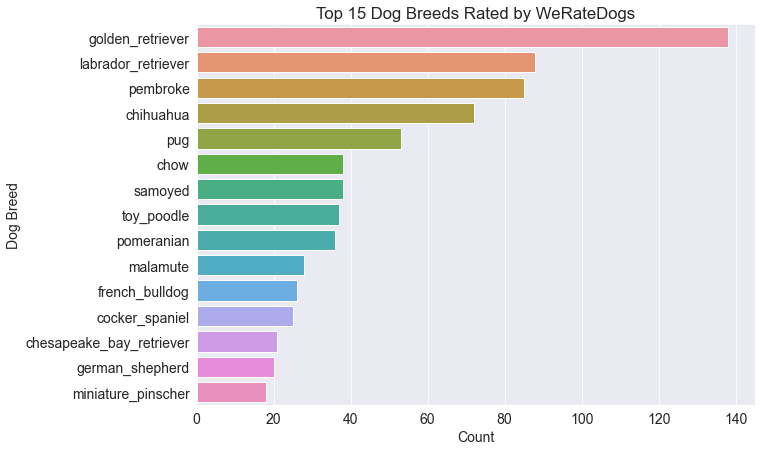

In [602]:
plt.figure(figsize=(10,7))
sns.barplot(x=top_dog_breeds.values, y=top_dog_breeds.index)
plt.title("Top 15 Dog Breeds Rated by WeRateDogs")
plt.xlabel("Count")
plt.ylabel("Dog Breed");

Golden retrievers, Labrador retrievers and pembroke are the top 3 dog breeds that got rated by WeRateDogs with a count of 138, 88 and 85 respectively.

### 2. Who are the top 3 good boys/girls?

We'll only deal with dogs that have a name for this analysis.

In [603]:
# subsetting rows where name is not NaN
dogs_with_names = master_df[master_df.name.notna()]
good_dogs = dogs_with_names.sort_values('rating', ascending=False).head()

In [604]:
good_dogs

,tweet_id,timestamp,source,text,expanded_urls,name,retweet_count,favorite_count,jpg_url,img_num,dog_breed,dog_stage,rating
724,749981277374128128,2016-07-04 15:00:45+00:00,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,Atticus,2269,4765,NaN,NaN,NaN,NaN,177.600000
506,786709082849828864,2016-10-13 23:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,Logan,5704,17317,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,1.0,pomeranian,NaN,7.500000
390,810984652412424192,2016-12-19 23:06:23+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,"https://www.gofundme.com/sams-smile,https://tw...",Sam,1325,5035,https://pbs.twimg.com/media/C0EyPZbXAAAceSc.jpg,1.0,golden_retriever,NaN,3.428571
1957,778027034220126208,2016-09-20 00:24:34+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,Sophie,1490,6174,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1.0,clumber,pupper,2.700000
337,819006400881917954,2017-01-11 02:21:57+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Sunny. She was also a very good First ...,https://twitter.com/dog_rates/status/819006400...,Sunny,17722,42880,NaN,NaN,NaN,doggo,1.400000


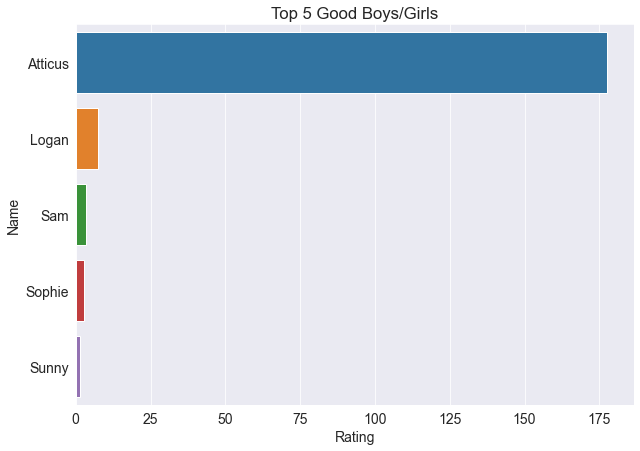

In [605]:
plt.figure(figsize=(10,7))
sns.barplot(y=good_dogs.name, x=good_dogs.rating)
plt.title("Top 5 Good Boys/Girls")
plt.ylabel("Name")
plt.xlabel("Rating");

Looks like Atticus, Logan and Sam are the top 3 good dogs with ratings of 177.6, 7.5, 3.4. I found out that there's no invalid outlier in this dataset 😄, Atticus, Logan and Sam all got high ratings because of their costumes but Atticus seemed to be dressed better.

### 3. What's everybody's top 10 favorite dogs?

We'll also have to use dogs with names for this one.

In [611]:
favorite_dogs = dogs_with_names.sort_values('favorite_count', ascending=False).head(10)

In [612]:
favorite_dogs

,tweet_id,timestamp,source,text,expanded_urls,name,retweet_count,favorite_count,jpg_url,img_num,dog_breed,dog_stage,rating
404,807106840509214720,2016-12-09 06:17:20+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Stephan. He just wants to help. 13/10 ...,https://twitter.com/dog_rates/status/807106840...,Stephan,51423,111184,https://pbs.twimg.com/ext_tw_video_thumb/80710...,1.0,chihuahua,NaN,1.3
1926,866450705531457537,2017-05-22 00:28:40+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Jamesy. He gives a kiss to every other...,https://twitter.com/dog_rates/status/866450705...,Jamesy,30055,108491,https://pbs.twimg.com/media/DAZAUfBXcAAG_Nn.jpg,2.0,french_bulldog,pupper,1.3
57,879415818425184262,2017-06-26 19:07:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Duddles. He did an attempt. 13/10 some...,https://twitter.com/dog_rates/status/879415818...,Duddles,37262,92499,https://pbs.twimg.com/ext_tw_video_thumb/87941...,1.0,english_springer,NaN,1.3
338,819004803107983360,2017-01-11 02:15:36+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Bo. He was a very good First Doggo. 14...,https://twitter.com/dog_rates/status/819004803...,Bo,34416,82399,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,1.0,standard_poodle,doggo,1.4
90,870374049280663552,2017-06-01 20:18:38+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She really likes the planet. Wou...,https://twitter.com/dog_rates/status/870374049...,Zoey,22656,73708,https://pbs.twimg.com/media/DBQwlFCXkAACSkI.jpg,1.0,golden_retriever,NaN,1.3
1419,676219687039057920,2015-12-14 01:58:31+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Kenneth. He's stuck in a bubble. 10/10...,https://twitter.com/dog_rates/status/676219687...,Kenneth,27646,70661,NaN,NaN,NaN,NaN,1.0
64,877736472329191424,2017-06-22 03:54:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Aja. She was just told she's a good do...,https://twitter.com/dog_rates/status/877736472...,Aja,15734,69037,https://pbs.twimg.com/media/DC5YqoQW0AArOLH.jpg,2.0,chesapeake_bay_retriever,NaN,1.3
32,884925521741709313,2017-07-12 00:01:00+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Earl. He found a hat. Nervous about wh...,https://twitter.com/dog_rates/status/884925521...,Earl,14943,67011,https://pbs.twimg.com/media/DEfjEaNXkAAtPlj.jpg,1.0,italian_greyhound,NaN,1.2
273,830583320585068544,2017-02-12 01:04:29+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Lilly. She just parallel barked. Kindl...,https://twitter.com/dog_rates/status/830583320...,Lilly,15365,62245,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1.0,labrador_retriever,NaN,1.3
20,887473957103951883,2017-07-19 00:47:34+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Canela. She attempted some fancy porch...,https://twitter.com/dog_rates/status/887473957...,Canela,14952,59974,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2.0,pembroke,NaN,1.3


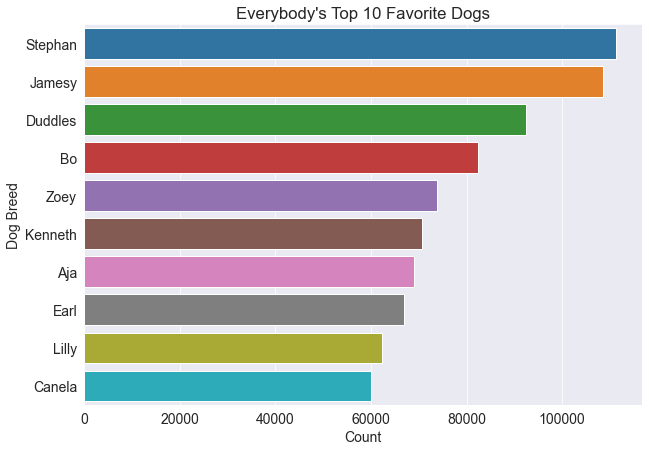

In [613]:
plt.figure(figsize=(10,7))
sns.barplot(x=favorite_dogs.favorite_count, y=favorite_dogs.name)
plt.title("Everybody's Top 10 Favorite Dogs")
plt.xlabel("Count")
plt.ylabel("Dog Breed");

The most favorite dog is Stephan with 111.1K likes and 51.4K retweets.

### 4. What is the average rating of dogs in respect to their dog stages?

In [622]:
dog_stage_avg_rating =  master_df.groupby('dog_stage').mean()['rating']

In [628]:
dog_stage_avg_rating

dog_stage
doggo      1.175581
floofer    1.180000
pupper     1.082051
puppo      1.208000
Name: rating, dtype: float64

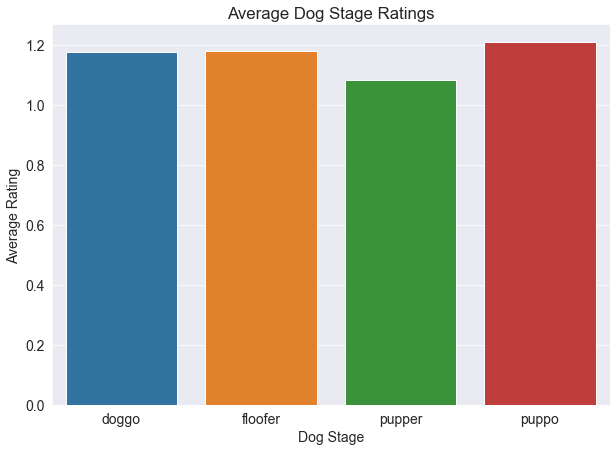

In [632]:
plt.figure(figsize=(10,7))
sns.barplot(x=dog_stage_avg_rating.index, y=dog_stage_avg_rating.values)
plt.title("Average Dog Stage Ratings")
plt.xlabel("Dog Stage")
plt.ylabel("Average Rating");

It looks like puppos were rated, on an average, higher than other dog stages. While puppers have the lowest average rating.

### 5. Who are the best dogs of the different dog stages?

In [692]:
dog_stage_max_ratings =  dogs_with_names.loc[dogs_with_names.groupby('dog_stage')['rating'].idxmax()]
dog_stage_max_ratings.drop(['timestamp','expanded_urls','source','text'],axis=1)

,tweet_id,name,retweet_count,favorite_count,jpg_url,img_num,dog_breed,dog_stage,rating
9,890240255349198849,Cassie,6067,27840,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1.0,pembroke,doggo,1.4
1909,883360690899218434,Grizzwald,3061,19874,https://pbs.twimg.com/media/DEJT3FeXoAAtwUy.jpg,1.0,chow,floofer,1.3
1957,778027034220126208,Sophie,1490,6174,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,1.0,clumber,pupper,2.7
2154,889531135344209921,Stuart,1874,13311,https://pbs.twimg.com/media/DFg_2PVW0AEHN3p.jpg,1.0,golden_retriever,puppo,1.3


We can see that Sophie the pupper had the highest rating of 2.7 while Grizzwald the floofer and Stuart the puppo had the least rating of 1.3 with Cassie the doggo in the middle with 1.4.

## Inferences and Conclusions
This was a reallt fun dataset to wrangle and although, there's still more cleaning that can be done, I believe the insights that I was able to derive are interesting. Let's revisits the questions that were posed earlier on.

### Q1. What are the popular dog breeds that got rated by WeRateDogs?
I found out that golden retrievers, Labrador retrievers and pembroke were the top 3 dog breeds that got rated by WeRateDogs with a count of 138, 88 and 85 respectively.

### Q2. Who are the top 3 good boys/girls?
For this question, I only dealt with records that had valid dog names. I found out that Atticus, Logan and Sam were the top 3 good dogs with ratings of 177.6, 7.5, 3.4. Even though there were outliers in this dataset, they didn't impact the ratings because those doggo deserved it. Atticus, Logan and Sam all got high ratings because of their costumes but Atticus seemed to be dressed better.

### Q3. What's everybody's top 10 favorite dogs?
Also working with records that have valid names and using the `favorite_count` as a measure, Stephan came out as the most favorite dog with 111.1K likes and 51.4K retweets followed by Jamesy with 108.5K likes and 30.1K retweets.

### Q4. What is the average rating of dogs in respect to their dog stages?
It was found that puppos were rated, on an average, higher than other dog stages with an average of 1.21. While puppers have the lowest average rating of 1.08.

### Q5. Who are the best dogs of the different dog stages?
It was noticed that Sophie the pupper had the highest rating of 2.7 while Grizzwald the floofer and Stuart the puppo had the least rating of 1.3 with Cassie the doggo in the middle with 1.4.

## Limitations
* A reasonable piece of the dataset had missing names and dog stages. This is a data entry issue because the source wasn't consistent with providing the names and dog stages.
* The image prediction dataset can be improved on. It had a hard time properly identifying the breed of most puppies and images that had other items in it. Further work can be done to improve its prediction.

## References
* [Dog Breed Identification, Kaggle](https://www.kaggle.com/competitions/dog-breed-identification/data)
